In [1]:
%load_ext  autoreload
%autoreload 2

In [2]:
import sys
import random
sys.path.append('..')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.spatial import distance
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

seed = 1

In [5]:
sns.set_context("paper")

In [6]:
# Load the file
df = pd.read_csv('../data/german_credit_data.csv')
df = df.drop(df.columns[0], axis=1) # remove the index column

# Quantize credit amount, duration and age into 5 bins
amount_series = df.loc[:, 'Credit amount']
df.loc[:, 'Credit amount'] = pd.qcut(amount_series, 5)

duration_series = df.loc[:, 'Duration']
df.loc[:, 'Duration'] = pd.qcut(duration_series, 5)

duration_series = df.loc[:, 'Age']
df.loc[:, 'Age'] = pd.qcut(duration_series, 5)

# Set Job type to object for one-hot encoding
df.loc[:, 'Job'] = df.loc[:, 'Job'].astype(object)

# Perform one-hot encoding
df = pd.get_dummies(df)
# Drop binary features
df = df.drop(columns=['Sex_male', 'Risk_bad'])

# Separate features from targets
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1]

print('Examples are represented as {}-dimensional vectors.'.format(df_X.shape[1]))

Examples are represented as 38-dimensional vectors.


In [7]:
# Convert to numpy
X = df_X.values.astype('int8')
y = df_y.values.astype('int8')
print('Shape of X: {}. Shape of y: {}.'.format(X.shape, y.shape))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Shape of X: (1000, 38). Shape of y: (1000,).


((900, 38), (900,), (100, 38), (100,))

### XGBoost baseline

In [8]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

clf.score(X_test, y_test)*100

/home/bogdan/Workspace/padML-code/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


76.0

### Logistic regression

In [9]:
# Fit logistic regression and perform CV
clf = LogisticRegressionCV(
    cv=5, 
    n_jobs=-1, 
    random_state=seed
)
clf.fit(X_train, y_train)

# Get best score and C value
mean_scores = np.mean(clf.scores_[1], axis=0)
best_idx = np.argmax(mean_scores)
best_score = mean_scores[best_idx]
best_C = clf.Cs_[best_idx]

print('Best score is: {:.2f}%. Best C is: {:.4f}.'.format(best_score*100, best_C))
print('Test score is: {:.2f}%.'.format(clf.score(X_test, y_test)*100))

Best score is: 73.56%. Best C is: 0.3594.
Test score is: 73.00%.


### SVM

In [10]:
params = {
    'kernel': ('linear', 'rbf'),
    'C': [9, 10, 11],
}

svc = SVC(probability=True)
clf = GridSearchCV(svc, params, cv=5)
clf.fit(X_train, y_train)

print('Best score is: {:.2f}%. Best params is: {}.'.format(
    clf.best_score_*100, clf.best_params_))
print('Test score is: {:.2f}%.'.format(
    clf.score(X_test, y_test)*100))

svm_params = clf.best_params_

Best score is: 74.22%. Best params is: {'C': 10, 'kernel': 'rbf'}.
Test score is: 77.00%.


In [11]:
class TransformationWrapper(object):
    amount_start_idx = df_X.columns.get_loc("Credit amount_(249.999, 1262.0]")
    duration_start_idx = df_X.columns.get_loc("Duration_(3.999, 12.0]")
    purpose_start_idx = df_X.columns.get_loc("Purpose_business")
    
    def __init__(self, x, decrease_amount=False, decrease_duration=True):
        self.root = x
        self.decrease_amount = decrease_amount
        self.decrease_duration = decrease_duration
        
        # Slices in the vector for each features
        self.static = self.root[:TransformationWrapper.amount_start_idx]
        self.amount = self.root[TransformationWrapper.amount_start_idx:TransformationWrapper.duration_start_idx]
        self.duration = self.root[TransformationWrapper.duration_start_idx:TransformationWrapper.purpose_start_idx]
        self.purpose = self.root[TransformationWrapper.purpose_start_idx:]
    
    def _get_neighbour(self, x, direction='pos'):
        """Get the neighbouring value in a quantized one-hot feature vector."""
        idx = np.argmax(x)
        if direction == 'pos' and idx != len(x) - 1:
            return np.roll(x, 1).tolist()
        elif direction == 'neg' and idx != 0:
            return np.roll(x, -1).tolist()
        return []

    def _expand_neighbours(self, field, directions=None):
        """Expand neighbouring values of a quantized feature."""
        if directions is None:
            directions = ['pos', 'neg']
            
        child_fields = []
        for direction in directions:
            child_fields.append(self._get_neighbour(field, direction=direction))

        child_fields = [x for x in child_fields if len(x) > 0]
        return np.array(child_fields, dtype='uint8')
    
    def _expand_all(self, field):
        """Expand all values of a categorical feature."""
        child_fields = []
        for i in range(1, len(field)):
            child_fields.append(np.roll(field, i))
        return child_fields

    def expand(self):
        """Generate new transformation."""
        
        children = []
        
        # Expand "credit amount".
        for c in self._expand_neighbours(
                self.amount,
                directions=['pos', 'neg'] if self.decrease_amount else ['pos']):
            child = np.concatenate((self.static, c, self.duration, self.purpose))
            children.append(child)
        
        # Expand "duration".
        for c in self._expand_neighbours(
                self.duration,
                directions=['pos', 'neg'] if self.decrease_duration else ['pos']):
            child = np.concatenate((self.static, self.amount, c, self.purpose))
            children.append(child)
        
        # Expand "purpose".
        for c in self._expand_all(self.purpose):
            child = np.concatenate((self.static, self.amount, self.duration, c))
            children.append(child)
        return children
    
    def __repr__(self):
        return 'TransformationWrapper({})'.format(self.root)

# Adversarial test examples

In [12]:
def hash_fn(example):
    return hash(str(example))

def generate_all_transformations(initial_example, transformation_kwargs=None):
    if transformation_kwargs is None:
        transformation_kwargs = {}

    result = []
    closed = set()
    
    queue = [initial_example]
    while queue:
        current_example = queue.pop()            
        current_example_wrapped = TransformationWrapper(
            current_example, **transformation_kwargs)
        for next_example in current_example_wrapped.expand(): 
            h = hash_fn(next_example)
            if h not in closed:
                closed.add(h)
                queue.insert(0, next_example)
                result.append(next_example)
            
    return result

In [13]:
def get_adversarial_transformations(clf, initial_example, target_class=1):
    assert clf.predict([example])[0] != target_class
    transformations = np.array(generate_all_transformations(initial_example))
    classes = clf.predict(transformations)
    adv_transformations = transformations[classes == target_class]
    return adv_transformations

In [14]:
def cost_fn(initial_example, examples):
    return np.linalg.norm(examples - initial_example, ord=1, axis=1) / 2

example = X[1]
transformations = get_adversarial_transformations(clf, example)
cost_fn(example, transformations)

array([1., 1., 2., 1., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2.])

In [15]:
def confidence_increase(initial_example, examples, target_class=1):
    """increase in confidence for 'accept' decision"""
    initial_confidence = clf.predict_proba([initial_example])[0, target_class]
    confidences = clf.predict_proba(examples)[:, target_class]
    return confidences - initial_confidence

def amount_increase(initial_example, examples, target_class=1):
    """increase in loan amount (bins)"""
    initial_amount = np.argmax(TransformationWrapper(initial_example).amount) + 1
    result = []
    for example in examples:
        wrapped_example = TransformationWrapper(example)
        amount = np.argmax(wrapped_example.amount) + 1
        increase = amount - initial_amount
        result.append(increase)
    return np.array(result)
          
# Alternative --- increase amount.
performance_metric_fn = amount_increase

In [16]:
initial_example = X_test[10]
perfs = performance_metric_fn(
    initial_example,
    get_adversarial_transformations(clf, initial_example))

In [17]:
target_class = 1
transformations_by_idx = {}
for i, x in enumerate(tqdm_notebook(X)):
    if clf.predict([x])[0] != target_class:
        transformations = get_adversarial_transformations(clf, x)
        transformations_by_idx[i] = transformations

Proportion of adversarial examples successfully found:

In [18]:
np.mean([len(ts) > 0 for ts in transformations_by_idx.values()])

1.0

## Plot all adversarial examples

That is, all transformations that change the decision of the classifier.

In [19]:
trans_data_df = pd.DataFrame(columns=['initial', 'cost', 'perf'])
for i, ts in tqdm_notebook(transformations_by_idx.items()):
    cs = cost_fn(X[i], ts)
    ps = performance_metric_fn(X[i], ts)
    trans_data_df = trans_data_df.append(
        {'initial': i, 'cost': 0., 'perf': 0.}, ignore_index=True)
    for t, c, p in zip(ts, cs, ps):
        trans_data_df = trans_data_df.append(
            {'initial': i, 'cost': c, 'perf': p},
            ignore_index=True)

In [20]:
def diff(x, t):
    diff_idx = np.where(x != t)
    diff_df = pd.DataFrame([x[diff_idx], t[diff_idx]],
                           columns=df.columns[diff_idx])
    return diff_df

[]

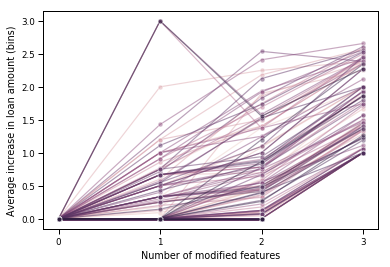

In [21]:
fig, ax = plt.subplots()
sns.lineplot(
    data=trans_data_df.sort_values('perf'),
    x='cost', y='perf', hue='initial',
    ci=None, legend=False, marker='o', markevery=1, alpha=.5,
    ax=ax)

ax.set_xticks([0, 1, 2, 3])
ax.set_xlabel('Number of modified features')
ax.set_ylabel('Average ' + performance_metric_fn.__doc__)

plt.plot()

[]

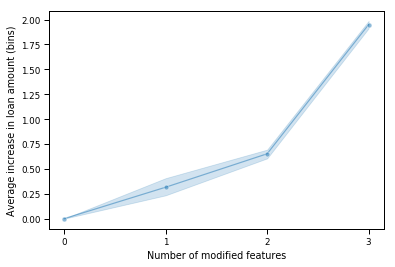

In [22]:
fig, ax = plt.subplots()
sns.lineplot(
    data=trans_data_df.sort_values('perf'),
    x='cost', y='perf', ci=99,
    legend=False, marker='o', markevery=1, alpha=.5,
    ax=ax)

ax.set_xticks([0, 1, 2, 3])
ax.set_xlabel('Number of modified features')
ax.set_ylabel('Average ' + performance_metric_fn.__doc__)

plt.plot()

## Plot max-confidence ('best') adversarial examples

That is, those adversarial examples that maximally increase the confidence of the classifier.

In [23]:
best_transformations = {}
for i in transformations_by_idx.keys():
    ts = transformations_by_idx[i]
    if len(ts) > 0:
        ps = performance_metric_fn(X[i], ts)
        best_idx = max(range(len(ts)), key=lambda idx: ps[idx])
        best_transformations[i] = ts[best_idx]

In [24]:
best_trans_df = pd.DataFrame(columns=['initial', 'cost', 'perf'])
for i, t in tqdm_notebook(best_transformations.items()):
    c = cost_fn(X[i], [t])[0]
    p = performance_metric_fn(X[i], [t])[0]
    #best_trans_df = best_trans_df.append(
    #    {'initial': i, 'cost': 0., 'perf': 0.}, ignore_index=True)
    best_trans_df = best_trans_df.append(
        {'initial': i, 'cost': c, 'perf': p}, ignore_index=True)

[]

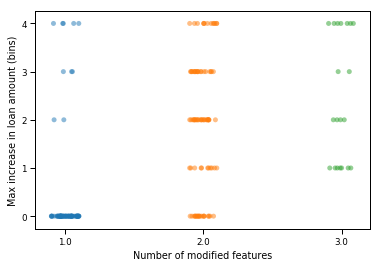

In [25]:
fig, ax = plt.subplots()

sns.stripplot(
    data=best_trans_df.sort_values('perf'),
    x='cost', y='perf',
    alpha=.5, jitter=True,
)

ax.set_xticks([0, 1, 2, 3])
ax.set_xlabel('Number of modified features')
ax.set_ylabel('Max ' + performance_metric_fn.__doc__)

plt.plot()

[]

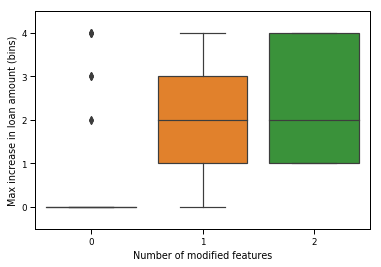

In [26]:
fig, ax = plt.subplots()

sns.boxplot(
    data=best_trans_df.sort_values('perf'),
    x='cost', y='perf'
)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['0', '1', '2'])
ax.set_xlabel('Number of modified features')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['0', '1', '2', '3', '4'])
ax.set_ylabel('Max ' + performance_metric_fn.__doc__)
ax.set_ylim(-0.5, 4.5)

plt.plot()